<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 1 - Data preparation

**Contribution:** ....

**Goal of this step:** ....

## 1. Setup of the environment

Below the necessary libraries are installed and loaded into the environment.

In [6]:
!pip install -q beautifulsoup4==4.13.4
!pip install -q docling==2.31.0

In [257]:
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, Comment
import docling
from docling.document_converter import DocumentConverter
import matplotlib.pyplot as plt
import tempfile

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

## 2. Loading the raw data

### Loading

We go through the subdirectories inside the data-folder. Inside those folders the individual html-files will be read and the content will be saved together with the information of the file-name and the path of the file (to store in which subfolder it was located).

In [12]:
# Definition of data folder
data_folder = os.path.join(base_folder, 'data')

In [ ]:
# List to hold the dictionaries
data = []

# Walk through all directories and subdirectories
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.html'):
            file_path = os.path.join(root, file)

            # Read the content of the HTML file
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # Add a dictionary to the list
            data.append({
                'folder_path': root,
                'file_name': file,
                'full_path': file_path,
                'html_content': content
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Optionally save DataFrame, e.g. to CSV or pickle for later use
# df.to_csv('html_files_content.csv', index=False)
# df.to_pickle('html_files_content.pkl')

# Show first rows to verify
print(df.head())

In [49]:
pd.set_option('display.max_colwidth', 50)
df.head()

,folder_path,file_name,full_path,html_content
0,/content/drive/MyDrive/AdvGenAI/data/de_intern...,der-r-pionier1.html,/content/drive/MyDrive/AdvGenAI/data/de_intern...,"<div class=""text-image cq-dd-image"">\n<p>Währe..."
1,/content/drive/MyDrive/AdvGenAI/data/de_intern...,web-of-science-alles-neu-macht-der--januar-.html,/content/drive/MyDrive/AdvGenAI/data/de_intern...,"<div class=""text-image cq-dd-image"">\n<p><a cl..."
2,/content/drive/MyDrive/AdvGenAI/data/de_intern...,swiss-life-sciences-2014-experten-gesucht.html,/content/drive/MyDrive/AdvGenAI/data/de_intern...,"<div class=""text-image cq-dd-image"">\n<h2>Staf..."
3,/content/drive/MyDrive/AdvGenAI/data/de_intern...,mendeley-literaturverwaltung.html,/content/drive/MyDrive/AdvGenAI/data/de_intern...,"<div class=""text-image cq-dd-image"">\n<p><a cl..."
4,/content/drive/MyDrive/AdvGenAI/data/de_intern...,mehr-orientierung.html,/content/drive/MyDrive/AdvGenAI/data/de_intern...,"<div class=""text-image cq-dd-image"">\n<p>Das S..."


### Checking completeness of loading

**Number of files**

Below we compare the number of documents collected by the function into the Dataframe with a selection of all files in the data folder.

In the check 3 files were discovered that were not part of the dataframe. After inspection it was discovered that those are `.DS_Store`file, for which it makes sense that they were not included.

In [19]:
# Dataframe
print(f"Number of files in the DataFrame: {len(df)}")

Number of files in the DataFrame: 4390


In [20]:
# Files in Data folder
print(f"Number of files in the data folder:")
!find "$data_folder" -type f | wc -l

Number of files in the data folder:
4393


In [25]:
!find "$data_folder" -type f | sort > folder_files.txt
df['full_path'].sort_values().to_csv('df_files.txt', index=False, header=False)
!sort folder_files.txt -o folder_files.txt
!sort df_files.txt -o df_files.txt
!comm -23 folder_files.txt df_files.txt

/content/drive/MyDrive/AdvGenAI/data/de_internal/2013/.DS_Store
/content/drive/MyDrive/AdvGenAI/data/de_internal/2015/.DS_Store
/content/drive/MyDrive/AdvGenAI/data/de_internal/2024/.DS_Store


**Checking for empty files**

Below we print out the rows of the dataframe with empty contents.

In [172]:
df[df['html_content'].isna()].head(10)

,folder_path,file_name,full_path,html_content
872,/content/drive/MyDrive/AdvGenAI/data/de_internal/2023/06,neue-indesign-vorlagen-fuer-mehr-barrierefreiheit.html,/content/drive/MyDrive/AdvGenAI/data/de_internal/2023/06/neue-indesign-vorlagen-fuer-mehr-barrierefreiheit.html,NaN
893,/content/drive/MyDrive/AdvGenAI/data/de_internal/2024/02,call-2024-foerderprogramm-internationale-kooperation-in-der-lehre.html,/content/drive/MyDrive/AdvGenAI/data/de_internal/2024/02/call-2024-foerderprogramm-internationale-kooperation-in-der-lehre.html,NaN
1212,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2021/08,einstein-quiz.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2021/08/einstein-quiz.html,NaN
1847,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2016/08,pp_pitch_elgar_fleisch.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2016/08/pp_pitch_elgar_fleisch.html,NaN
2045,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10,annette-oxenius-erhaelt-cloetta-preis.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/annette-oxenius-erhaelt-cloetta-preis.html,NaN
2049,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10,kleider-virtuell-anprobieren.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/kleider-virtuell-anprobieren.html,NaN
2050,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10,neue-daten-sprechen-fuer-magma-auf-dem-mars.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/neue-daten-sprechen-fuer-magma-auf-dem-mars.html,NaN
2080,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11,proteinformen-zeigen-parkinson-krankheit-an.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11/proteinformen-zeigen-parkinson-krankheit-an.html,NaN
2083,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11,kunst-aus-dem-computer.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11/kunst-aus-dem-computer.html,NaN
2090,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/09,elektroflugzeug-e-sling-hebt-ab.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/09/elektroflugzeug-e-sling-hebt-ab.html,NaN


After checking the files in the original data source we concluded that those files were empty files and therefore it was not a problem in the process of the data loading. We therefore exclude those rows from the dataframe.

In [175]:
df = df[~df['html_content'].isna()].copy()

### Saving the data to storage

In [215]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-01-raw-data.csv'), index=False)

## 3. Parsing and cleaning the HTML files

### Loading the data from storage

In [239]:
# Load csv from Google Drive Storage to Dataframe
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-01-raw-data.csv'))

In [240]:
df[["html_content"]].head(5)

,html_content
0,"<div class=""text-image cq-dd-image"">\n<p>Während andere in den Sechziger-Jahren Lokführer werden wollten, war für Martin Mächler schon immer klar:..."
1,"<div class=""text-image cq-dd-image"">\n<p><a class=""eth-link"" href=""http://www.library.ethz.ch/de/Ueber-uns/Aktuell/Web-of-Science-Alles-neu-macht-..."
2,"<div class=""text-image cq-dd-image"">\n<h2>Staffnet</h2>\n<p>Das <a class=""eth-link"" href=""https://ethz.ch/services/de.html"">Info-Portal</a> für Mi..."
3,"<div class=""text-image cq-dd-image"">\n<p><a class=""eth-link"" href=""http://www.library.ethz.ch/de/Dienstleistungen/Schulungen-Tutorials-Fuehrungen/..."
4,"<div class=""text-image cq-dd-image"">\n<p>Das Studierendenleben an der ETH dreht sich momentan nur um eines: Die anstehenden Prüfungen. Während and..."


### BeautifulSoup

#### Definition of cleaning function

Below a function is defined to clean the stored strings of the html-files using `BeautifulSoup`. It extracts the title and main texts of the documents while removing various elements that are not of interest for the further analysis (for example style and navigation elements).

In [241]:
def clean_html(html_content):
    from bs4 import BeautifulSoup, Comment
    import re

    soup = BeautifulSoup(html_content, 'html.parser')

    # Title extraction
    title = soup.title.get_text(strip=True) if soup.title else ''

    # Remove unwanted elements
    for el in soup(['script', 'style', 'header', 'footer', 'nav', 'iframe', 'meta', 'link']):
        el.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    # Get the content from body if exists
    content = soup.body or soup

    # get_text with separator
    clean_text = content.get_text(separator='\n\n').strip()

    # Post-process: Collapse excessive blank lines
    clean_text = re.sub(r'\n{3,}', '\n\n', clean_text)

    return title, clean_text

#### Application of cleaning function on subset

**Add description (trying it out with a subset), the function creates one long string (no headers atleast in the subset)**

In [242]:
# create a subset of the dataframe for testing
df_test = df.sample(n=5).copy()

In [243]:
df_test['title'], df_test['clean_content'] = zip(*df_test['html_content'].apply(clean_html))

In [244]:
pd.set_option('display.max_colwidth', 150)
df_test[['html_content', 'title', 'clean_content']].head()

,html_content,title,clean_content
3868,"<div class=""text-image cq-dd-image"">\n<p>“As soon as the project was presented, I knew it was the one for me,” says Shuaixin Qi. Since September 2...",,"“As soon as the project was presented, I knew it was the one for me,” says Shuaixin Qi. Since September 2018, the sixth-semester mechanical engine..."
667,"<div class=""text-image cq-dd-image"">\n<p>Welche Informationen der ETH dürfen in Cloud-Dienste ausserhalb unserer Hochschule gespeichert werden? Un...",,Welche Informationen der ETH dürfen in Cloud-Dienste ausserhalb unserer Hochschule gespeichert werden? Und welche Richtlinien gelten für diese Clo...
3699,"<div class=""text-image cq-dd-image"">\n<p>Recognizing their pioneering results, ETH Zurich awards the Ruzicka Prize to two scientists of the Depart...",,"Recognizing their pioneering results, ETH Zurich awards the Ruzicka Prize to two scientists of the Department of Chemistry and Applied Biosciences..."
2823,"<div class=""text-image cq-dd-image"">\n<p>At the end of March, the transition period for the migration to the new <a class=""eth-link"" href=""https:/...",,"At the end of March, the transition period for the migration to the new \n\nexternal page\n\nswisscovery\n\ncall_made\n\n research platform that w..."
4021,"<div class=""text-image cq-dd-image"">\n<p>Two researchers at ETH Zurich – atmospheric physicist Ulrike Lohmann and political scientist Frank Schimm...",,Two researchers at ETH Zurich – atmospheric physicist Ulrike Lohmann and political scientist Frank Schimmelfennig – have each been awarded an Adva...


In [222]:
from IPython.display import HTML
import textwrap
for idx, row in df_test.iterrows():
    print(f"Row {idx}:")
    display(HTML(row['html_content']))
    # Display the cleaned text
    print("\nCleaned Text:\n")
    print(textwrap.fill(str(row['clean_content']), width=100))
    print(100 * "-")
    print("\n")

Row 2023:



Cleaned Text:

Im Meerwasser tummeln sich unzählige Lebewesen, vom grössten Tier der Erde, dem Blauwal, bis hin zu
winzigen Mikroorganismen. Diese sind nicht nur sehr zahlreich, sondern auch wichtig für das
Funktionieren des gesamten Öko- und Klimasystems. So produzieren photosynthetisch aktive
Mikroorganismen wie Cyanobakterien rund 50 Prozent des in der Atmosphäre vorhandenen Sauerstoffs.
Auch entziehen solche Kleinstlebewesen der Atmosphäre Kohlendioxid und wirken damit der
Klimaerwärmung entgegen.  Trotz ihrer Bedeutung ist die Vielfalt der Meeres-Mikroorganismen erst
ansatzweise erforscht. Eine Gruppe von Forschenden um Shinichi Sunagawa, Professor für Mikrobiomik,
hat deshalb mit der Gruppe von Jörn Piel, beide am Institut für Mikrobiologie der ETH Zürich, und
Serina Robinson von der Eawag auf die Suche gemacht.  Um neue, bakteriell fabrizierte Naturstoffe
aufzuspüren, untersuchten Sunagawa und seine Mitarbeitenden DNA-Daten von 1000 Wasserproben aus
allen Meeresregionen der Wel


Cleaned Text:

Working with Müller Illien Landscape Architects, Timbatec and other partners from industry and
research, researchers from the group led by ETH architecture professors Fabio Gramazio and Matthias
Kohler are creating a green architectural sculpture for the Tech Cluster Zug. Soaring to a height of
22.5 metres, the structure will consist of five geometrically complex wooden pods that are slightly
offset from each other and supported by eight thin steel pillars. The sculpture, named after the
Babylonian queen to whom the ancient Hanging Gardens of Babylon have been attributed, is being
designed and built using innovative digital methods that were developed as part of the project.  AI
proposes a clever design  In the conventional design process for projects like this, architects try
to take the different requirements of a building or structure into account in its design, and then
adjust that design until all the requirements are met in the best way possible. Not so with
Semir


Cleaned Text:

Bei der Krankheit Hydrozephalus sammelt sich Hirnflüssigkeit in den Hohlräumen des Gehirns. Eine
Therapiemöglichkeit ist, diese Flüssigkeit über eine von Chirurg:innen angelegte und als Shunt
bezeichnete Verbindung in die Bauchhöhle abfliessen zu lassen. Bei solchen reinmechanischen Shunts
kommt es aber oft zu Komplikationen. Das siebenköpfige Vieshunt-Team möchte deshalb die
Behandlungsmethode durch die Entwicklung eines mechatronischen Smart Shunt verbessern. Die
Studierenden entwickeln ein intelligentes System, welches den Hirndruck automatisch auf ein gesundes
Niveau regelt.  Fokusprojekte  In Fokusprojekten wenden Bachelorstudierende der Studiengänge
Maschinenbau und Elektrotechnik das Gelernte konkret an und entwickeln selbständig ein Produkt.
Ausgehend von einer marktorientierten Problemstellung durchschreiten die Teams alle Prozesse der
Produktentwicklung realitätsnah: Marketing, Konzeption, Design, Engineering, Simulation, Entwurf und
Produktion. Am 31. Mai 202


Cleaned Text:

This month marks the end of my time as Rector at ETH Zurich. Numerous people have asked me whether
I’ve been successful in this role in promoting women. In fact, it’s been a key goal throughout the
past 25 years. Let’s see…. as I focus on areas that I impacted on directly.  Women in science still
have to put in an above-average effort to be seen at all: Donna Strickland had no Wikipedia entry
before she won the Nobel Prize in Physics in 2018. Although I can’t award Nobel Prizes, ETH has
increased the quota of women among our honorary doctors (to 41%) and honorary councillors (to 25%)
over the last seven years putting outstanding women into the spotlight. Why? Because they deserve
this recognition, and our students need role models, know that every door is open to them and that
they can achieve anything.  Of course, new appointments and boosting female participation come under
this section as well. I’m extremely thankful that ETH Zurich has Joël Mesot at its helm, a man 


Cleaned Text:

160 years ago, 68 students began their studies at the newly founded Polytechnic Institute, today's
ETH Zurich.  You can read about this in German on the Blog   ETHeritage   and in English on the
ETH Global News  .     Subscribe to Newsletter     Subscribe to the Newsletter for internal news
Staffnet  Info portal   for employees with the key information about what’s going on at ETH Zurich.
----------------------------------------------------------------------------------------------------




#### Application of cleaning function on full Dataframe

In [223]:
df['bs_html_title'], df['bs_html_content'] = zip(*df['html_content'].apply(clean_html))

In [224]:
pd.set_option('display.max_colwidth', 150)
df_test[['html_content', 'title', 'clean_content']]

,html_content,title,clean_content
2023,"<div class=""text-image cq-dd-image"">\n<p>Im Meerwasser tummeln sich unzählige Lebewesen, vom grössten Tier der Erde, dem Blauwal, bis hin zu winzi...",,"Im Meerwasser tummeln sich unzählige Lebewesen, vom grössten Tier der Erde, dem Blauwal, bis hin zu winzigen Mikroorganismen. Diese sind nicht nur..."
3988,"<div class=""text-image cq-dd-image"">\n<p>Working with Müller Illien Landscape Architects, Timbatec and other partners from industry and research, ...",,"Working with Müller Illien Landscape Architects, Timbatec and other partners from industry and research, researchers from the group led by ETH arc..."
1985,"<div class=""text-image cq-dd-image"">\n<p>Bei der Krankheit Hydrozephalus sammelt sich Hirnflüssigkeit in den Hohlräumen des Gehirns. Eine Therapie...",,"Bei der Krankheit Hydrozephalus sammelt sich Hirnflüssigkeit in den Hohlräumen des Gehirns. Eine Therapiemöglichkeit ist, diese Flüssigkeit über e..."
4245,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--medium"">\n<img alt=""Sarah Springman"" src=""/en/news-and-e...",,This month marks the end of my time as Rector at ETH Zurich. Numerous people have asked me whether I’ve been successful in this role in promoting ...
2704,"<div class=""text-image cq-dd-image"">\n<p>160 years ago, 68 students began their studies at the newly founded Polytechnic Institute, today's ETH Zu...",,"160 years ago, 68 students began their studies at the newly founded Polytechnic Institute, today's ETH Zurich.\n\nYou can read about this in Germa..."


**Not visible in the Notebook but in the Data there are double newlines, Add more text describing that**

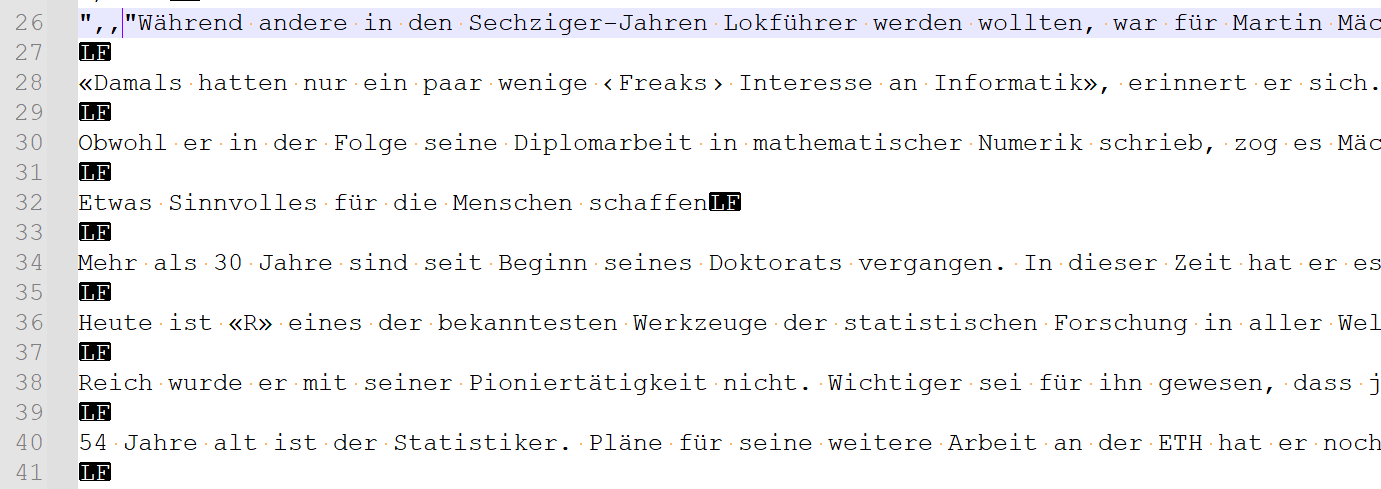

#### Saving the data to storage

In [225]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-02-bs.csv'), index=False)

### Docling

In [258]:
# Initialize the Docling converter
converter = DocumentConverter()

def html_to_markdown(html_content):
    """Convert HTML content to markdown using Docling"""
    try:
        # Create a temporary HTML file
        with tempfile.NamedTemporaryFile(suffix='.html', mode='w', delete=False) as temp:
            temp.write(html_content)
            temp_path = temp.name

        # Convert the HTML file
        result = converter.convert(temp_path)

        # Clean up the temporary file
        os.unlink(temp_path)

        # Return markdown
        return result.document.export_to_markdown()
    except Exception as e:
        return f"Error converting content: {str(e)}"

# Apply the conversion function to create a new markdown_content column
df_test['markdown_content'] = df_test['html_content'].apply(html_to_markdown)

In [259]:
df_test

,folder_path,file_name,full_path,html_content,title,clean_content,markdown_content,docling_text_content
3868,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2019/05,focus-projects.html,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2019/05/focus-projects.html,"<div class=""text-image cq-dd-image"">\n<p>“As soon as the project was presented, I knew it was the one for me,” says Shuaixin Qi. Since September 2...",,"“As soon as the project was presented, I knew it was the one for me,” says Shuaixin Qi. Since September 2018, the sixth-semester mechanical engine...",## Helping others\n\nQi’s colleague Michael Heid knew back when he started his mechanical engineering studies that an opportunity to work on a Foc...,Helping others\n\nQi’s colleague Michael Heid knew back when he started his mechanical engineering studies that an opportunity to work on a Focus ...
667,/content/drive/MyDrive/AdvGenAI/data/de_internal/2021/08,cloud-nutzung-und-klassifizierung-von-informationen-das-wird-neu.html,/content/drive/MyDrive/AdvGenAI/data/de_internal/2021/08/cloud-nutzung-und-klassifizierung-von-informationen-das-wird-neu.html,"<div class=""text-image cq-dd-image"">\n<p>Welche Informationen der ETH dürfen in Cloud-Dienste ausserhalb unserer Hochschule gespeichert werden? Un...",,Welche Informationen der ETH dürfen in Cloud-Dienste ausserhalb unserer Hochschule gespeichert werden? Und welche Richtlinien gelten für diese Clo...,"## Neue Rahmenbedingungen für Cloud-Dienste\n\nUm vertrauliche Daten in externen Cloud-Diensten zu speichern und zu verarbeiten, braucht es Rahmen...","Neue Rahmenbedingungen für Cloud-Dienste\n\nUm vertrauliche Daten in externen Cloud-Diensten zu speichern und zu verarbeiten, braucht es Rahmenbed..."
3699,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2017/11,ruzicka-prize.html,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2017/11/ruzicka-prize.html,"<div class=""text-image cq-dd-image"">\n<p>Recognizing their pioneering results, ETH Zurich awards the Ruzicka Prize to two scientists of the Depart...",,"Recognizing their pioneering results, ETH Zurich awards the Ruzicka Prize to two scientists of the Department of Chemistry and Applied Biosciences...","## Generation of electricity from heat\n\nCars, laptops, refrigerators, and even cell phones: any device we use produces heat and thereby wastes a...","Generation of electricity from heat\n\nCars, laptops, refrigerators, and even cell phones: any device we use produces heat and thereby wastes a lo..."
2823,/content/drive/MyDrive/AdvGenAI/data/en_internal/2021/03,vollstaendige-umstellung-auf-swisscovery-zum-1-april-2021.html,/content/drive/MyDrive/AdvGenAI/data/en_internal/2021/03/vollstaendige-umstellung-auf-swisscovery-zum-1-april-2021.html,"<div class=""text-image cq-dd-image"">\n<p>At the end of March, the transition period for the migration to the new <a class=""eth-link"" href=""https:/...",,"At the end of March, the transition period for the migration to the new \n\nexternal page\n\nswisscovery\n\ncall_made\n\n research platform that w...",## Subscribe to Newsletter\n\nSubscribe to the Newsletter for internal news\n\n## Staffnet\n\nInfo portal for employees with the key information a...,Subscribe to Newsletter\n\nSubscribe to the Newsletter for internal news\n\nStaffnet\n\nInfo portal for employees with the key information about w...
4021,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2021/04,two-advanced-grants-for-eth.html,/content/drive/MyDrive/AdvGenAI/data/en_news_events/2021/04/two-advanced-grants-for-eth.html,"<div class=""text-image cq-dd-image"">\n<p>Two researchers at ETH Zurich – atmospheric physicist Ulrike Lohmann and political scientist Frank Schimm...",,Two researchers at ETH Zurich – atmospheric physicist Ulrike Lohmann and political scientist Frank Schimmelfennig – have each been awarded an Adva...,## An uncertain future\n\nThis year’s Advanced Grants were awarded as part of the EU’s Horizon 2020 research and innovation programm